# **1. Import thư viện**

In [1]:
# 1. Import thư viện (Đầy đủ như bạn yêu cầu)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Các thư viện Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, auc, accuracy_score,f1_score,)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# **2. Chuẩn bị dữ liệu**

In [3]:
df = pd.read_csv('ECommerce_Dataset_cleaned_model.csv')

In [4]:
df.shape

(5630, 15)

In [5]:
df.head()

,Churn,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,DaySinceLastOrder,CashbackAmount,DevicePerTenure
0,1,3,6,3,3,Laptop & Accessory,2,Single,9,1,11,1,5,160,0.75
1,1,1,8,3,4,Mobile Phone,3,Single,7,1,15,0,0,121,4.00
2,1,1,30,2,4,Mobile Phone,3,Single,6,1,14,0,3,120,4.00
3,1,3,15,2,4,Laptop & Accessory,5,Single,8,0,23,0,3,134,4.00
4,1,1,12,3,3,Mobile Phone,5,Single,3,0,11,1,3,130,3.00


In [6]:
# Xác định biến đầu vào và mục tiêu
target = 'Churn'
X = df.drop(columns=[target])
y = df[target]

In [7]:
# Xác định cột số và cột phân loại
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()


In [8]:
print(f"\nCategorical: {cat_cols}")
print(f"Numerical: {num_cols}")


Categorical: ['PreferedOrderCat', 'MaritalStatus']
Numerical: ['CityTier', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'DaySinceLastOrder', 'CashbackAmount', 'DevicePerTenure']


In [9]:
# Chia dữ liệu 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train shape: {X_train.shape} | Test shape: {X_test.shape}")

Train shape: (4504, 14) | Test shape: (1126, 14)


# **3. Tạo Pipeline (Tiền xử lý + Mô hình)**

In [10]:
#ColumnTransformer (StandardScaler+OneHotEncoder)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

In [11]:
#PipeLine: Preprocessor ->SMOTE -> KNN
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', KNeighborsClassifier()) # Các tham số sẽ đi tìm bởi GridSearch ở dưới
])

# **4. Cross validation**

In [12]:
#Tìm K tối ưu (GridSearchCV) Range(1-21)
param_grid = {
    'classifier__n_neighbors': range(1, 22, 2),
    'classifier__weights': ['uniform', 'distance'], # Thử thêm trọng số khoảng cách
    'classifier__metric': ['euclidean', 'manhattan'] # Thử 2 loại khoảng cách
}

#Thiết lập GridSearch
grid_search = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
# Lấy kết quả tốt nhất
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"\nTham số tốt nhất: {best_params}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 44 candidates, totalling 220 fits

Tham số tốt nhất: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
Best Cross-Validation Score: 0.9564


In [13]:
# Dùng best_model để dự báo chéo lại trên tập Train nhằm vẽ biểu đồ đánh giá nội bộ
y_cv_pred = cross_val_predict(best_model, X_train, y_train, cv=5)
y_cv_proba = cross_val_predict(best_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

print("Classification Report (Validation):")
print(classification_report(y_train, y_cv_pred))

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      3746
           1       0.61      0.91      0.73       758

    accuracy                           0.89      4504
   macro avg       0.79      0.89      0.83      4504
weighted avg       0.92      0.89      0.89      4504



# **5. Huấn luyện & dự đoán**

In [14]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)

# **6. Đánh giá mô hình**


In [15]:
#Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       936
           1       0.65      0.96      0.78       190

    accuracy                           0.91      1126
   macro avg       0.82      0.93      0.86      1126
weighted avg       0.93      0.91      0.91      1126



In [16]:
# Các chỉ số tổng hợp
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"-> Accuracy: {acc:.4f}")
print(f"-> F1-Score (Class 1): {f1:.4f}")
print(f"-> ROC-AUC Score (Average): {roc_auc_score(y_test, y_prob[:, 1]):.4f}")

-> Accuracy: 0.9076
-> F1-Score (Class 1): 0.7778
-> ROC-AUC Score (Average): 0.9737


**Nhận xét:**
* Mô hình KNN đạt **accuracy 91%** và **ROC-AUC 0.97**, cho thấy hiệu suất phân loại tổng thể vượt trội so với mức cơ sở (Logistic_Regression).
  * Lớp 0 (Non-Churn): **precision 0.99** và **recall 0.90**, mô hình xác định nhóm khách hàng trung thành với độ tin cậy rất cao, chỉ có một lượng nhỏ bị dự đoán nhầm sang Churn.
  * Lớp 1 (Churn): **recall đạt 0.96**, mô hình phát hiện được gần như toàn bộ khách hàng sắp rời bỏ. Tuy nhiên, **precision 0.65** cho thấy mô hình chấp nhận False Positive để đảm bảo không bỏ sót rủi ro.
* **Nhìn chung,** mô hình xử lý rất tốt dữ liệu mất cân bằng (nhờ SMOTE), ưu tiên tối đa việc không bỏ sót khách hàng rời bỏ (High Recall), rất phù hợp với chiến lược giữ chân khách hàng.

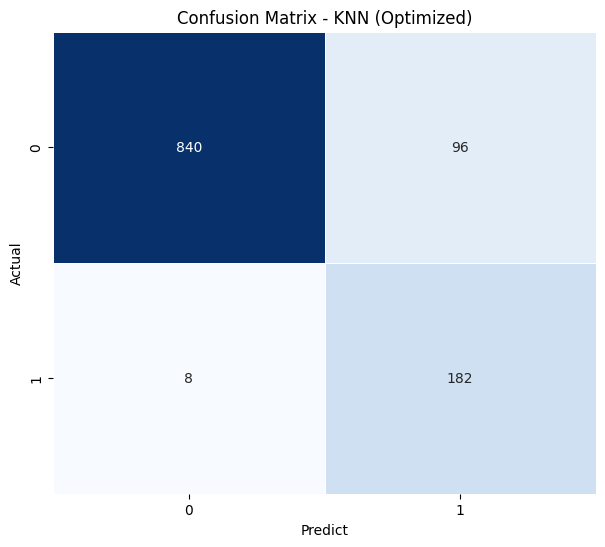

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            cbar=False, linewidths=0.5)
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN (Optimized)')
plt.savefig('KNN_Confusion_Matrix.png')
plt.show()

**Nhận xét:**

* Dự đoán đúng **182** khách hàng có khả năng **rời bỏ**, giúp doanh nghiệp tập trung nguồn lực giữ chân nhóm nguy cơ cao này.
* Nhận diện chính xác **840** khách hàng **trung thành**, giúp khoanh vùng đúng đối tượng cần chăm sóc.

**Kết luận:** Mô hình có xu hướng nhạy cảm, chấp nhận việc báo động giả cao **(96 ca)** để đổi lấy khả năng bao quát rủi ro tốt nhất **(chỉ bỏ sót 8 ca)**. Tuy precision chưa cao, nhưng mô hình hoàn thành tốt mục tiêu quan trọng là không để lọt khách hàng rời bỏ.


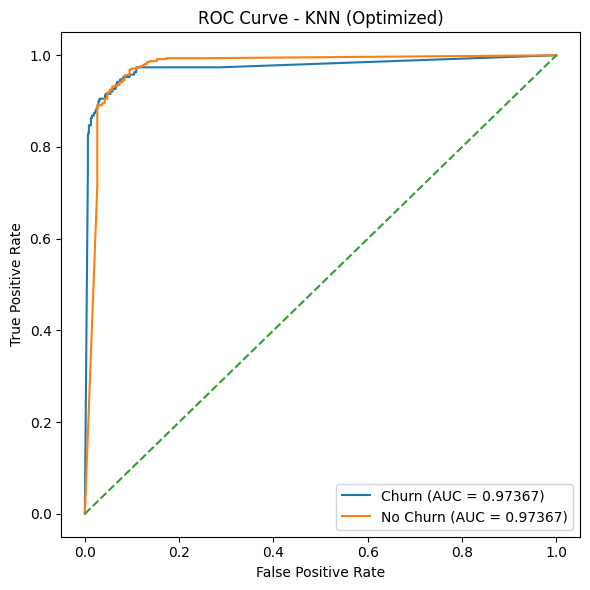

In [18]:
#ROC Curve
#Churn (1)
fpr_1, tpr_1, _ = roc_curve(y_test, y_prob[:, 1])
auc_1 = auc(fpr_1, tpr_1)

#No Churn (0)
fpr_0, tpr_0, _ = roc_curve(1 - y_test, y_prob[:, 0])
auc_0 = auc(fpr_0, tpr_0)

# Vẽ biểu đồ
plt.figure(figsize=(6, 6))
plt.plot(fpr_1, tpr_1, label=f'Churn (AUC = {auc_1:.5f})')
plt.plot(fpr_0, tpr_0, label=f'No Churn (AUC = {auc_0:.5f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN (Optimized)')
plt.legend()
plt.tight_layout()
plt.show()


**Nhận xét:**

* **AUC = 0.97367** cho thấy mô hình có năng lực phân tách xuất sắc giữa hai lớp, độ tin cậy của xác suất dự báo cao hơn nhiều so với các mô hình cơ sở.

* Đường ROC tiệm cận sát góc trên bên trái chứng tỏ mô hình duy trì được tỷ lệ True Positive Rate cao, khá hiệu quả trong việc xếp hạng mức độ rủi ro rời bỏ của khách hàng.

In [19]:
#Lưu mô hình
joblib.dump(best_model, 'model_knn_smote_optimized.joblib')
print("\nĐã lưu mô hình thành công: model_knn_smote_optimized.joblib")


Đã lưu mô hình thành công: model_knn_smote_optimized.joblib
